<h1 align="center">Eye Diseases Classification 👁️</h1>
<p style="text-align:center;">The dataset consists of Normal, Diabetic Retinopathy, Cataract and Glaucoma retinal images where each class have approximately 1000 images. These images are collected from various sorces like IDRiD, Oculur recognition, HRF etc.</p>

## Imports

In [1]:
import os
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torchmetrics import Accuracy, ConfusionMatrix
from torchmetrics.functional import f1_score, precision_recall

from ray import tune
from ray.air import session
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import DataLoader

/Users/sinaraoufi/miniforge3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load data

In [2]:
def load_data():
    t = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
        ]
    )

    return datasets.ImageFolder(root="dataset", transform=t)

## Split data into train-test

In [3]:
def train_test_split(dataset, train_size, random_state=42):
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    seed = torch.Generator().manual_seed(random_state)
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size], generator=seed
    )

    return train_dataset, test_dataset

In [4]:
dataset = load_data()

In [5]:
dataset

Dataset ImageFolder
    Number of datapoints: 4217
    Root location: dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
           )

In [6]:
train_dataset, test_dataset = train_test_split(dataset, 0.8)

In [7]:
# number of classes
K = len(set(dataset.targets))

In [8]:
print(f"Number of classes: {K}")

Number of classes: 4


## Convolutional neural network (CNN)

In [9]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, K),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.dense_layers(x)

        return x

In [10]:
model = CNN(K)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

### Exploring images

Label : cataract


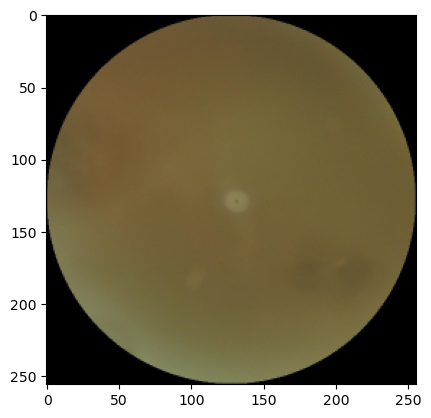

In [12]:
def display_image(image, label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(image.permute(1, 2, 0))


# display the first image in the dataset
display_image(*dataset[0])

## DataLoader

In [13]:
batch_size = 128
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, num_workers=1
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=1
)

### Visualizing the batch images

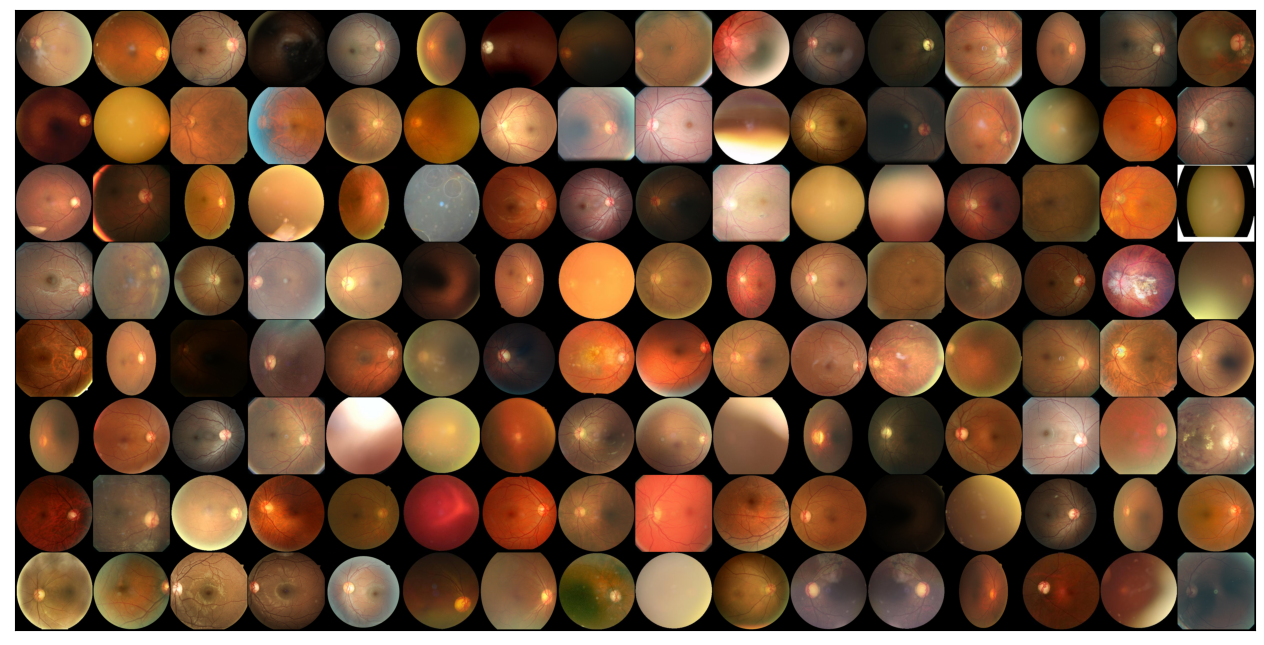

In [14]:
def show_batch(data_loader):
    """Plot images grid of single batch"""
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


show_batch(train_dataloader)

### Device configuration

In [15]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"

## Training function

In [16]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

    model.to(device)
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    accuracy = Accuracy(num_classes=K).to(device)
    for epoch in range(epochs):
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss
        train_loss = np.mean(train_loss)
        # Train accuracy
        train_accuracy = accuracy(outputs, targets)

        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss.append(loss.item())

        # Get test loss
        test_loss = np.mean(test_loss)
        # Test accuracy
        test_accuracy = accuracy(outputs, targets)

        # Save losses
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss

        print(
            f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}, \
        Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f},"
        )

    return train_losses, test_losses

In [17]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_dataloader, test_dataloader, epochs=20
)

Epoch 1/20: Train Loss: 1.34, Test Loss: 1.21,         Train Accuracy: 0.33, Test Accuracy: 0.43,
Epoch 2/20: Train Loss: 1.10, Test Loss: 1.04,         Train Accuracy: 0.56, Test Accuracy: 0.59,
Epoch 3/20: Train Loss: 0.95, Test Loss: 0.94,         Train Accuracy: 0.71, Test Accuracy: 0.66,
Epoch 4/20: Train Loss: 0.86, Test Loss: 0.86,         Train Accuracy: 0.71, Test Accuracy: 0.59,
Epoch 5/20: Train Loss: 0.82, Test Loss: 0.79,         Train Accuracy: 0.62, Test Accuracy: 0.68,
Epoch 6/20: Train Loss: 0.77, Test Loss: 0.75,         Train Accuracy: 0.76, Test Accuracy: 0.71,
Epoch 7/20: Train Loss: 0.74, Test Loss: 0.72,         Train Accuracy: 0.67, Test Accuracy: 0.74,
Epoch 8/20: Train Loss: 0.71, Test Loss: 0.68,         Train Accuracy: 0.64, Test Accuracy: 0.63,
Epoch 9/20: Train Loss: 0.69, Test Loss: 0.71,         Train Accuracy: 0.64, Test Accuracy: 0.66,
Epoch 10/20: Train Loss: 0.66, Test Loss: 0.65,         Train Accuracy: 0.69, Test Accuracy: 0.66,
Epoch 11/20: Train 

### Plot the losses

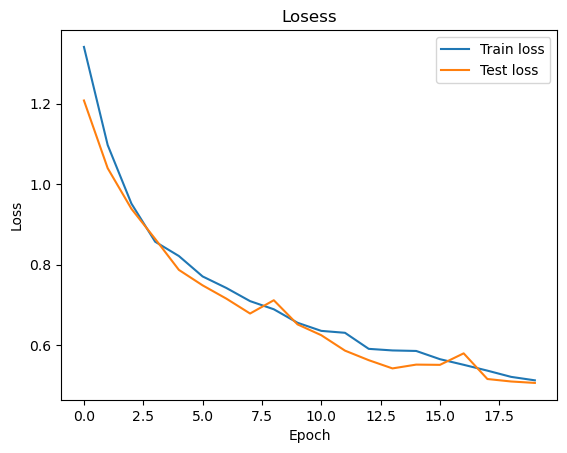

In [18]:
plt.title("Losess")
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Predection

In [19]:
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predections = torch.max(outputs, 1)

        y_pred_list.append(targets.cpu().numpy())
        y_true_list.append(predections.cpu().numpy())

targets = torch.tensor(np.concatenate(y_true_list))
preds = torch.tensor(np.concatenate(y_pred_list))

## Evaluations

### Confusion matrix

In [20]:
confmat = ConfusionMatrix(num_classes=K)
cm = confmat(preds, targets)

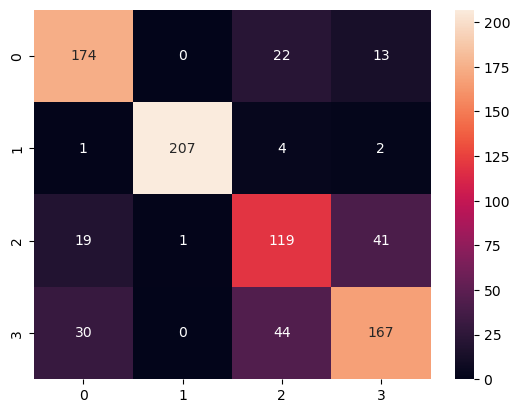

In [21]:
sn.heatmap(cm, annot=True, fmt=".0f")
plt.show()

### Accuracy

In [22]:
accuracy = Accuracy(num_classes=K).to(device)
accuracy = accuracy(preds, targets)
print(f"Accuracy: {100 * accuracy:.2f}%")

Accuracy: 79.03%


### Precision & Recall

In [23]:
precision, recall = precision_recall(preds, targets, average="macro", num_classes=K)
print(f"Precision: {100 * precision:.2f}%, Recall: {100 * recall:.2f}%")

Precision: 78.76%, Recall: 78.85%


### F1-score

In [24]:
f1_score = f1_score(preds, targets, num_classes=K)
print(f"F1-score: {100 * f1_score:.2f}%")

F1-score: 79.03%
